# GAN

In [109]:
import random
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(color_codes=True)

### Real (R) world data
The original, genuine data set which G tried to mimic. Sampled from gaussian distribution

In [2]:
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))

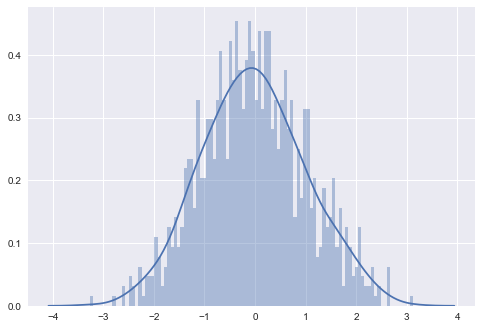

In [130]:
data = get_distribution_sampler(0, 1)(1000).numpy()
sns.distplot(data, bins=100)

### Input (I) to generator
This is the random noise that goes into the generator as a source of entropy. Sampled from uniform distribution making it much difficult for G to simply mimic by simply shift and scale R.

In [112]:
def get_generator_input_sampler():
    return lambda n, m: torch.rand(n, m)

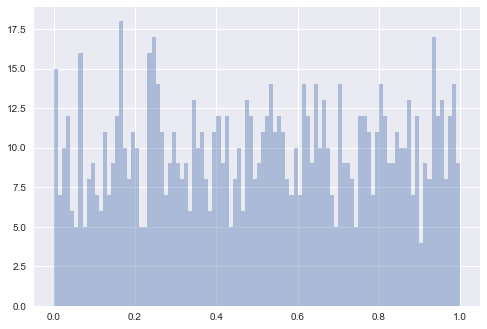

In [129]:
data = get_generator_input_sampler()(1, 1000).numpy()
sns.distplot(data, bins=100, kde=False)

### Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

### Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [6]:
D = Discriminator(1, 10, 2)
D

Discriminator (
  (fc1): Linear (1 -> 10)
  (fc2): Linear (10 -> 10)
  (fc3): Linear (10 -> 2)
)

In [7]:
def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)


In [66]:
data = Variable(get_distribution_sampler(0, 1)(10))
data

Variable containing:
 1.5638 -0.7706  1.4020 -1.2225  0.2368  1.2775  0.6356  0.7359 -0.3499  0.0394
[torch.FloatTensor of size 1x10]

In [67]:
decorate_with_diffs(data, 1)

Variable containing:

Columns 0 to 9 
 1.5638 -0.7706  1.4020 -1.2225  0.2368  1.2775  0.6356  0.7359 -0.3499  0.0394

Columns 10 to 19 
 1.2090 -1.1254  1.0472 -1.5773 -0.1180  0.9227  0.2808  0.3811 -0.7047 -0.3154
[torch.FloatTensor of size 1x20]